In [1]:
#Running on real hardware

## Imports

In [2]:

import random
import ast

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

# Import libraries to be able to run on IBM quantum computers
from qiskit import Aer
from qiskit import *


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e5_patch
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data 

In [4]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
## malign and benign aee reverted !!!!!!!!!!!!!

diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

print('Malign: ', df['diagnosis'].value_counts()[0])
print('Benign: ', df['diagnosis'].value_counts()[1])

Malign:  305
Benign:  195


In [6]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


In [7]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0]
non_fraud_df = df.loc[df['diagnosis'] == 1][:195]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
379,9013838,1.0,11.08,18.83,73.30,361.6,0.12160,0.21540,0.16890,0.06367,...,508.1,0.2184,0.9379,0.84020,0.25240,0.4154,0.14030,NaN,7,23
388,903011,0.0,11.27,15.50,73.38,392.0,0.08365,0.11140,0.10070,0.02757,...,450.0,0.1102,0.2809,0.30210,0.08272,0.2157,0.10430,NaN,2,28
156,8711202,1.0,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,...,1302.0,0.1418,0.3498,0.35830,0.15150,0.2463,0.07738,NaN,0,30
472,911384,0.0,14.92,14.93,96.45,686.9,0.08098,0.08549,0.05539,0.03221,...,906.6,0.1065,0.2791,0.31510,0.11470,0.2688,0.08273,NaN,0,30
150,871001501,0.0,13.00,20.78,83.51,519.4,0.11350,0.07589,0.03136,0.02645,...,616.7,0.1297,0.1105,0.08112,0.06296,0.3196,0.06435,NaN,1,29


In [8]:
sub_sample_corr = sub_sample_df.corr()

In [9]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [10]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    

In [11]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

In [12]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
240,0.316907,1.0,0.374642,0.207838,0.412042,0.240405,0.185437,0.135353
421,0.380756,1.0,0.454220,0.320463,0.456715,0.336035,0.313121,0.309314
313,0.162027,1.0,0.323368,0.132477,0.342397,0.257378,0.044269,0.073736
291,0.511684,1.0,0.434315,0.171282,0.450888,0.192780,0.239513,0.194063
395,0.271856,1.0,0.383838,0.172535,0.413984,0.217733,0.161581,0.344933


In [13]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
321,0.489691,1.000000,0.597930,0.145712,0.639845,0.277771,0.383996,0.140491
194,0.593471,1.000000,0.472134,0.259589,0.446171,0.322356,0.441252,0.196970
75,0.522337,1.000000,0.512739,0.347575,0.548557,0.196327,0.329920,0.207984
219,0.558419,0.833333,0.717357,0.177931,0.774140,0.168714,0.329871,0.270420
131,0.520275,1.000000,0.497213,0.200450,0.534406,0.176947,0.401938,0.160880


In [14]:
input_data=malign.to_numpy()

## Simulated performance

In [15]:
shots = 2500
nr_trash=2
nr_latent=2


trash_qubits1=[i for i in range(nr_trash)]
latent_qubits1=[i for i in range(nr_trash,nr_trash+nr_latent)]
trash_qubits2=[i for i in range(nr_trash+nr_latent,2*nr_trash+nr_latent)]
latent_qubits2=[i for i in range(2*nr_trash+nr_latent,2*(nr_trash+nr_latent))]
aux_qubits=[i for i in range(2*(nr_trash+nr_latent),2*(nr_trash+nr_latent)+2*nr_trash)]
swap_qubit=[2*(nr_trash+nr_latent)+2*nr_trash]

qubits=[*trash_qubits1, *latent_qubits1, *trash_qubits2, *latent_qubits2, *aux_qubits, *swap_qubit]


print("Qubits:", qubits)

#set up the device 
dev = qml.device("default.qubit", wires=qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [16]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])
    qml.CNOT(wires=[latent_qubits1[0],trash_qubits2[0]])
    qml.CNOT(wires=[latent_qubits2[0],trash_qubits1[0]])
    
    
    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

In [17]:
# get pretrained parameters
"""
file = open("Cancer_encoder_e5-SelectedFeautures_params500499.txt", "r")

contents = file.read()
params = ast.literal_eval(contents)

file.close()
pretrained_params=torch.tensor(params)
"""
params= [[ 0.09075912,  0.69908196,  0.68930513,  0.99063071,  0.15037739,
         0.27307128,  0.75808335,  0.81300807, -0.07095591,  0.39143257,
         0.1565683 ,  1.18832605,  0.7589207 ,  1.08535165,  0.99095568,
         1.19618317,  0.1041966 ,  0.37283352,  0.4353361 ,  0.78752949,
         0.40952572,  0.95521912,  0.6834643 ,  0.465881  , -0.02069283,
         0.30416467,  0.41168311,  0.0653198 ,  1.17969817,  0.61566686,
         0.55167881,  0.21057211,  1.06799534,  1.03548724,  0.62477483,
         0.64868715,  0.20048897,  0.77190856,  0.56113648,  0.11285003,
         0.7254919 ,  0.32705002,  0.28569874,  0.78913503,  0.43694008,
         1.07893717, -0.13233038,  1.14692199,  0.69239169,  0.66581732,
         0.54637515,  0.80126171,  0.46020506,  0.74211563,  0.37556434,
         0.66160512,  0.31816777,  0.22179046,  0.69066047,  0.51188035,
         0.35609274,  1.02791387, -0.01285879,  0.95679438,  1.04377943,
         0.20382128,  0.83205247, -0.03608208,  0.76442729,  0.72530747,
         0.9008025 ,  0.41431417,  0.70605203,  0.09671011,  0.11021917,
         0.16470133,  0.00837555,  0.13076675,  0.91113945,  0.86825062,
         0.29163113,  0.70535991,  0.42071167,  0.59382135,  0.16498272,
         0.54802089,  0.22437896,  0.30863581,  0.17384793,  0.72767136]], [[ 0.80379157,  0.95808257,  0.36796595,  0.27647238,  0.72238875,
         1.09783427, -0.05065132,  0.66306825,  0.79281171,  0.01632897,
         0.32736306,  0.5436408 ,  0.48209395,  0.1865278 ,  0.51882868,
         0.97625185,  0.90610854,  0.96774317,  0.61281054,  0.19275014,
         0.90699107,  0.36882372,  0.09601677,  0.1126743 ,  0.78029843,
         0.92228954,  0.02020907,  0.21877008,  0.24923627,  0.16181925,
         0.79818726,  0.56377631,  0.67932837,  0.16795401,  0.78150202,
         1.00846354,  0.26835487,  0.91354509,  0.47803688,  0.54311407,
         0.1205844 ,  0.22719395,  0.96540265,  0.45376574,  0.77944866,
         0.45454917,  0.30769456,  1.0216038 ,  0.56675099,  0.43581425,
         0.25495592,  0.77192506,  0.63166401,  0.09350117,  0.75345127,
         0.8257795 ,  0.60709482,  0.45441019,  0.39086306,  0.99063978,
         0.01605943,  1.03717476,  0.17132362,  0.64045384,  0.1268933 ,
         0.11105608,  0.34580086, -0.02066192,  0.40508233,  0.81741563,
         0.60395027,  0.85202809, -0.08236891,  0.57678802,  0.27276916,
         0.41265142,  0.53580181,  0.6826936 ,  0.68438073,  0.16370976,
         0.75737505,  0.70878525,  0.36960893,  0.67879954,  0.2640659 ,
         0.19937788,  0.39682091,  0.42706573,  0.52906846,  0.65047691]]

pretrained_params=torch.tensor(params)
print(pretrained_params)

tensor([[[ 0.0908,  0.6991,  0.6893,  0.9906,  0.1504,  0.2731,  0.7581,
           0.8130, -0.0710,  0.3914,  0.1566,  1.1883,  0.7589,  1.0854,
           0.9910,  1.1962,  0.1042,  0.3728,  0.4353,  0.7875,  0.4095,
           0.9552,  0.6835,  0.4659, -0.0207,  0.3042,  0.4117,  0.0653,
           1.1797,  0.6157,  0.5517,  0.2106,  1.0680,  1.0355,  0.6248,
           0.6487,  0.2005,  0.7719,  0.5611,  0.1129,  0.7255,  0.3271,
           0.2857,  0.7891,  0.4369,  1.0789, -0.1323,  1.1469,  0.6924,
           0.6658,  0.5464,  0.8013,  0.4602,  0.7421,  0.3756,  0.6616,
           0.3182,  0.2218,  0.6907,  0.5119,  0.3561,  1.0279, -0.0129,
           0.9568,  1.0438,  0.2038,  0.8321, -0.0361,  0.7644,  0.7253,
           0.9008,  0.4143,  0.7061,  0.0967,  0.1102,  0.1647,  0.0084,
           0.1308,  0.9111,  0.8683,  0.2916,  0.7054,  0.4207,  0.5938,
           0.1650,  0.5480,  0.2244,  0.3086,  0.1738,  0.7277]],

        [[ 0.8038,  0.9581,  0.3680,  0.2765,  0.7224,  1

In [18]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [19]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

np_malign = malign.to_numpy()
malign_data = [ torch.tensor([np_malign[i]]) for i in range(len(malign.to_numpy()))]


encoder_params = pretrained_params

/var/folders/3_/hxxz6cjj6k92q_tqrvht1tf80000gn/T/ipykernel_31958/2371207769.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180898435/work/torch/csrc/utils/tensor_new.cpp:201.)
  benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]


In [20]:
## Run on benign data:
benign_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    benign_flist.append(f.item())
    
print(min(benign_flist))
print(max(benign_flist))

0.683326188965412
0.8617870363542607


In [21]:
## Run on malign data:
malign_flist=[]
for b in malign_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.8226944727890678
0.8867009121997793


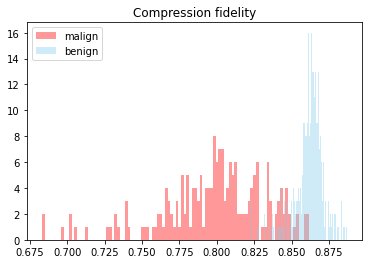

In [22]:
## remeber data waz reverted 

plt.hist(benign_flist, bins = 100 ,label="malign", color = "red",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [23]:
split=0.868


print("split:",split)
b_e=[]
for i in benign_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.868
benign classification accuracy: 1.0
malign classification accuracy: 0.19344262295081968
total accuracy: 0.508


## Real hardware 

In [24]:
"""
device_rigetti = "arn:aws:braket:::device/qpu/rigetti/Aspen-11"

# Note: please change the s3 directory accordingly based on your account if you want to run the code
my_bucket = f"amazon-braket-e2ddc0be70c2" # the name of the bucket
my_prefix = "e5results" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)
dev_rigetti_aws = qml.device('braket.aws.qubit', device_arn=device_rigetti, shots=2500*2, wires=qubits, s3_destination_folder=s3_folder)

"""

'\ndevice_rigetti = "arn:aws:braket:::device/qpu/rigetti/Aspen-11"\n\n# Note: please change the s3 directory accordingly based on your account if you want to run the code\nmy_bucket = f"amazon-braket-e2ddc0be70c2" # the name of the bucket\nmy_prefix = "e5results" # the name of the folder in the bucket\ns3_folder = (my_bucket, my_prefix)\ndev_rigetti_aws = qml.device(\'braket.aws.qubit\', device_arn=device_rigetti, shots=2500*2, wires=qubits, s3_destination_folder=s3_folder)\n\n'

In [25]:
"""
dev_qiskit = qml.device('qiskit.aer', wires=qubits, backend = 'qasm_simulator')
"""
token = 'bdfb136f41f48dcab8cfc1bad4d78a53ef82fc659bd63e6decfb01526e7897904f5726e4cb3014f34fbb40ab745b733b9fe6219a6d9c28a2ee45cf36da171abb'
IBMQ.save_account(token,overwrite=True)  #save your creds
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q-community', group='qhack-hackathon', project='16-qubit')
dev_qiskit = qml.device('qiskit.ibmq', wires=qubits, backend='ibmq_guadalupe',provider=provider)

In [26]:
@qml.qnode(dev_qiskit)
def training_circuit_real(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])
    qml.CNOT(wires=[latent_qubits1[0],trash_qubits2[0]])
    qml.CNOT(wires=[latent_qubits2[0],trash_qubits1[0]])
    
    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

In [27]:
def fidelity_real(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_real(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [30]:
## Run on benign data:
benign_flist=[]
for i in range(len(benign_data)):
    b=benign_data[i]
    f=fidelity_real(encoder_params, [b])
    np.savetxt('real_IBM/Testing_benign_e5_ent_sample' + str(i) + '.txt', [f])
    benign_flist.append(f.item())
    
print(min(benign_flist))
print(max(benign_flist))

0.4296875
0.609375


In [31]:
len(benign_flist)

195

In [35]:
## Run on malign data:
#malign_flist=[]
for i in  range (99,len(malign_data)):
    b=malign_data[i]
    
    f=fidelity_real(encoder_params, [b])
    np.savetxt('real_IBM/Testing_malign_e5_ent_sample' + str(i) + '.txt', [f])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.44140625
0.61328125


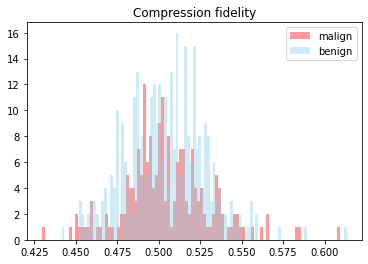

In [36]:
## remeber data waz reverted 

plt.hist(benign_flist, bins = 100 ,label="malign", color = "red",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [37]:
split=0.868


print("split:",split)
b_e=[]
for i in benign_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.868
benign classification accuracy: 1.0
malign classification accuracy: 0.0
total accuracy: 0.36044362292051757
